## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pathlib
import warnings

In [2]:
# Preprocessing
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer, MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from transformers import CyclicalTransformer, AverageTransformer, DateTransformer, SimpleDateTransformer

In [3]:
# Helper functions
from functions import calculate_vif

In [4]:
# Configuration
sns.set_theme(style='ticks', palette='mako', rc={"axes.spines.right": False, "axes.spines.top": False})
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
# Data
path_home = pathlib.Path.cwd()
uci_data = pd.read_csv(path_home / 'data' / 'UCI_data.csv')
uci_data.head()

,date,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,TARGET_energy
0,2016-04-19 20:30:00,22.200000,39.500000,20.566667,37.656667,22.230000,37.030000,22.318571,36.610000,20.633333,62.166667,8.823333,13.296667,21.00,29.318571,22.23,38.463333,19.926667,33.90,9.70,766.100000,65.5,3.500000,40.000000,3.350000,24.061869,24.061869,60
1,2016-03-05 04:40:00,20.356667,37.126667,17.566667,40.230000,20.890000,37.663333,18.700000,36.260000,18.463333,43.560000,1.230000,78.963333,18.39,32.290000,21.00,43.400000,18.390000,41.09,0.30,740.333333,99.0,1.000000,41.333333,0.100000,4.622052,4.622052,50
2,2016-03-14 12:40:00,20.926667,38.790000,21.100000,35.526667,21.600000,36.290000,21.000000,34.826667,18.100000,46.126667,6.033333,37.300000,21.29,27.566667,21.70,32.447500,19.390000,38.76,4.40,768.466667,72.0,6.000000,22.666667,-0.266667,5.635898,5.635898,80
3,2016-01-22 15:30:00,18.290000,38.900000,17.290000,39.260000,18.390000,39.326667,16.100000,38.790000,16.100000,47.700000,4.595000,94.945000,16.20,33.590000,17.78,41.663333,15.800000,39.20,3.35,760.600000,82.0,5.500000,41.000000,0.500000,49.216445,49.216445,40
4,2016-02-10 00:40:00,22.290000,42.333333,21.600000,40.433333,22.666667,43.363333,19.100000,40.900000,19.290000,50.745000,2.530000,92.190000,20.00,40.000000,23.10,46.090000,18.890000,43.73,3.20,738.900000,88.0,7.333333,56.000000,1.400000,47.617579,47.617579,60


In [6]:
print(f'Data shape: {uci_data.shape}')
uci_data.info()

Data shape: (19735, 28)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           19735 non-null  object 
 1   T1             19735 non-null  float64
 2   RH_1           19735 non-null  float64
 3   T2             19735 non-null  float64
 4   RH_2           19735 non-null  float64
 5   T3             19735 non-null  float64
 6   RH_3           19735 non-null  float64
 7   T4             19735 non-null  float64
 8   RH_4           19735 non-null  float64
 9   T5             19735 non-null  float64
 10  RH_5           19735 non-null  float64
 11  T6             19735 non-null  float64
 12  RH_6           19735 non-null  float64
 13  T7             19735 non-null  float64
 14  RH_7           19735 non-null  float64
 15  T8             19735 non-null  float64
 16  RH_8           19735 non-null  float64
 17  T9             19735 non-n

In [7]:
uci_data.describe()

,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,TARGET_energy
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,19.592106,50.949283,7.910939,54.609083,20.267106,35.388200,22.029107,42.936165,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033,101.496833
std,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,1.844623,9.022034,6.090347,31.149806,2.109993,5.114208,1.956162,5.224361,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634,104.380829
min,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,29.815000,-6.065000,1.000000,15.390000,23.200000,16.306667,29.600000,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322,10.000000
25%,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,18.277500,45.400000,3.626667,30.025000,18.700000,31.500000,20.790000,39.066667,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889,50.000000
50%,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,19.390000,49.090000,7.300000,55.290000,20.033333,34.863333,22.100000,42.375000,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653,60.000000
75%,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,20.619643,53.663333,11.256000,83.226667,21.600000,39.000000,23.390000,46.536000,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769,100.000000
max,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,25.795000,96.321667,28.290000,99.900000,26.000000,51.400000,27.230000,58.780000,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530,1110.000000


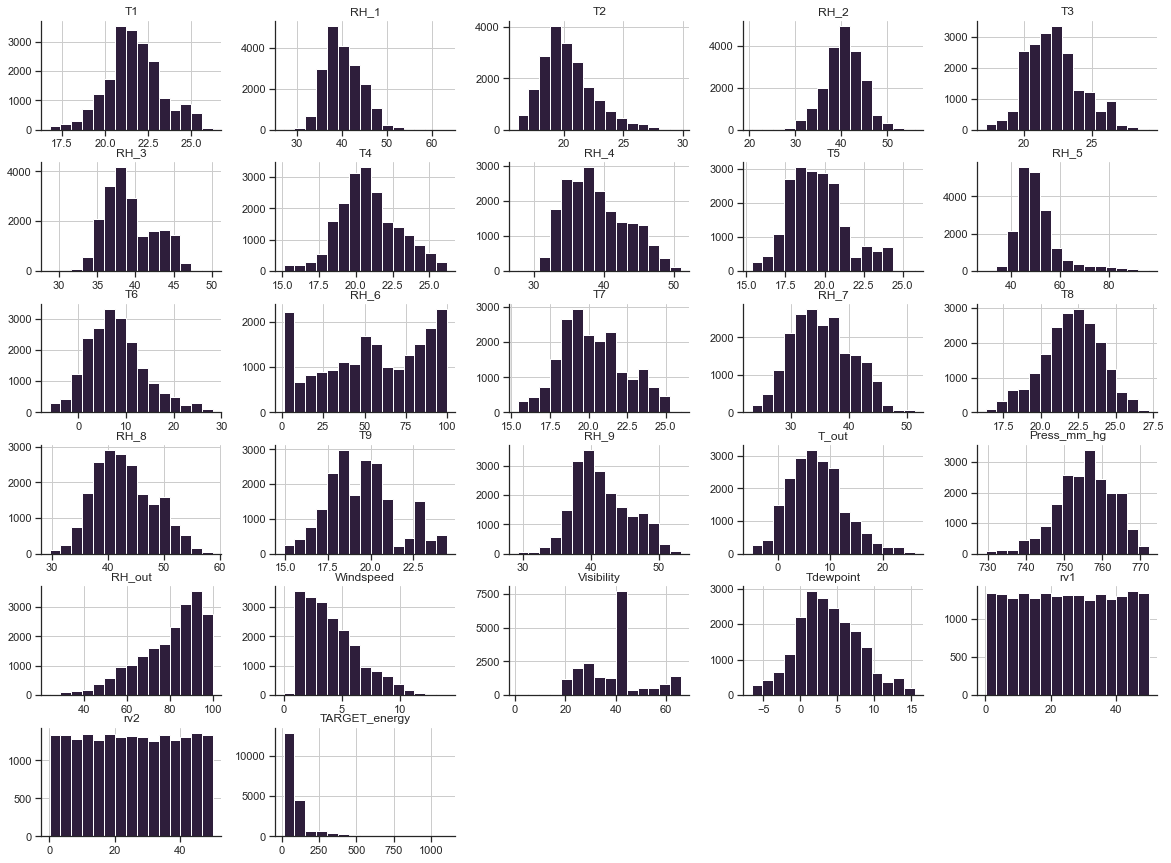

In [8]:
uci_data.hist(bins=15, figsize=(20,15))
plt.show()

#### Train test split

In [9]:
train, test = train_test_split(uci_data, train_size=0.8, test_size=0.2, random_state=27)
train.to_csv('data/train.csv', index=False)
test.to_csv('data/test.csv', index=False)

# Exploratory Data Analysis
- **Date** is not in a date format and will need to be split into more descriptive features such as **season**, **weekday vs. weekend**, time of day (**peak/ off peak**)
- **Temperature** variables (T1 - T9) all seem to fall between reasonable values, have relatively normal distributions and do not seem to contain any outliers
- Some **temperature** variables seem as if they may be multimodal, including T5, T7, T9
- Some **temperature** variables seem as if they may have a non-normal distribution, including T2
- **Humidity** variables (RH_1 - RH_9) seem mostly normally distributed
- RH_6 (humidity outside the building, north side) seems to have a lot of values bunch at 0%, indicating maybe there are missing values and they are encoded as 0
- Some **humidity** variables seem bimodal, such as (RH_3, RH_6, RH_8, RH_9)
- **RH_out** and **Windspeed** have exponential distributions
- **Visibility** has an extreme number of values around 40, indicating that mean or median imputation may have been used for missing values
- **rv_1** and **rv_2** seem to have a random, constant distribution, and the description of the value does not seem to add value to the dataset. These can probably be removed.
- The target variable **TARGET_energy** seems to be positively skewed, with a number of outliers in the positive direction

In [10]:
eda = pd.read_csv('data/train.csv')

## Scaling

#### Target feature: ENERGY_target
The target feature seems to have a long positive skew, indicating many positive outliers. A transformation may need to be applied to the target variable to account for this. Log transform seems to be the best at removing outliers, where square root transform still remains positively skewed.

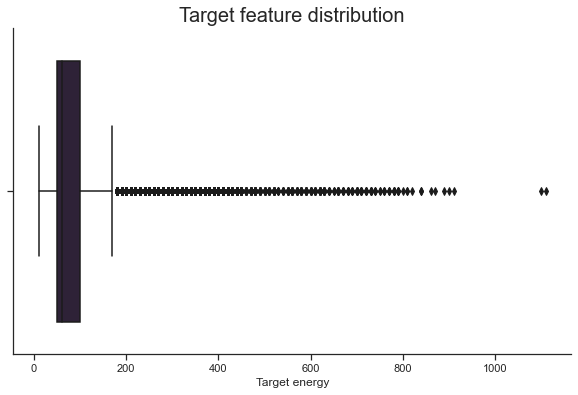

In [11]:
fig = plt.figure(figsize=(10,6))

sns.boxplot(eda['TARGET_energy'])

plt.title('Target feature distribution', fontsize=20)
plt.xlabel('Target energy')
plt.show()

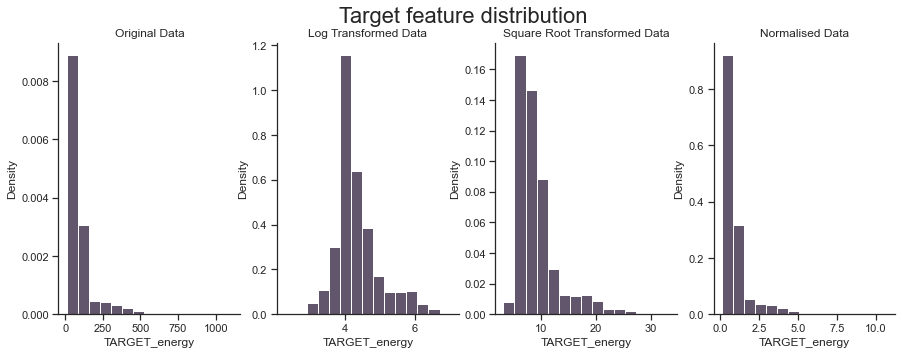

In [12]:
fig, ax = plt.subplots(1,4, figsize=(15,5))
fig.suptitle('Target feature distribution', fontsize=22)

target = eda['TARGET_energy']
target_log = np.log(target)
target_sqrt = np.sqrt(target)
target_norm = target/np.std(target)

sns.histplot(target, bins=15, stat='density', ax=ax[0])
sns.histplot(target_log, bins=15, stat='density', ax=ax[1])
sns.histplot(target_sqrt, bins=15, stat='density', ax=ax[2])
sns.histplot(target_norm, bins=15, stat='density', ax=ax[3])

ax[0].set_title('Original Data')
ax[1].set_title('Log Transformed Data')
ax[2].set_title('Square Root Transformed Data')
ax[3].set_title('Normalised Data')

plt.show()

#### Feature: Windspeed
Windspeed seems to have a non-normal distribution, where a square root transformation seems to work best when considering most other variables will follow a normalised process.

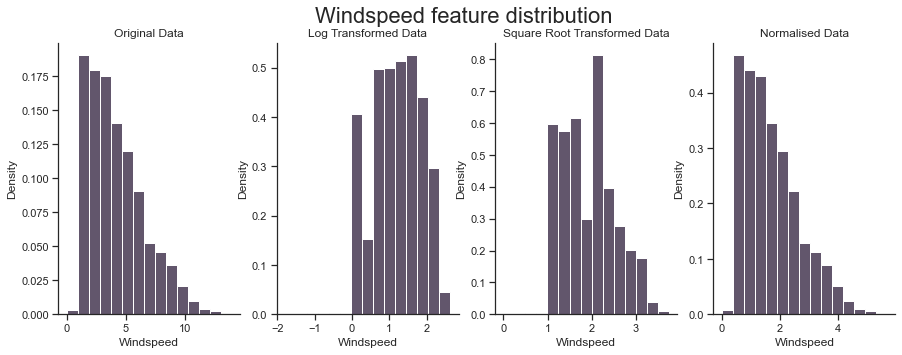

In [13]:
fig, ax = plt.subplots(1,4, figsize=(15,5))
fig.suptitle('Windspeed feature distribution', fontsize=22)

windspeed = eda['Windspeed']
windspeed_log = np.log(windspeed)
windspeed_sqrt = np.sqrt(windspeed)
windspeed_norm = windspeed/np.std(windspeed)

sns.histplot(windspeed, bins=15, stat='density', ax=ax[0])
sns.histplot(windspeed_log, bins=15, stat='density', ax=ax[1])
sns.histplot(windspeed_sqrt, bins=15, stat='density', ax=ax[2])
sns.histplot(windspeed_norm, bins=15, stat='density', ax=ax[3])

ax[0].set_title('Original Data')
ax[1].set_title('Log Transformed Data')
ax[2].set_title('Square Root Transformed Data')
ax[3].set_title('Normalised Data')

plt.show()

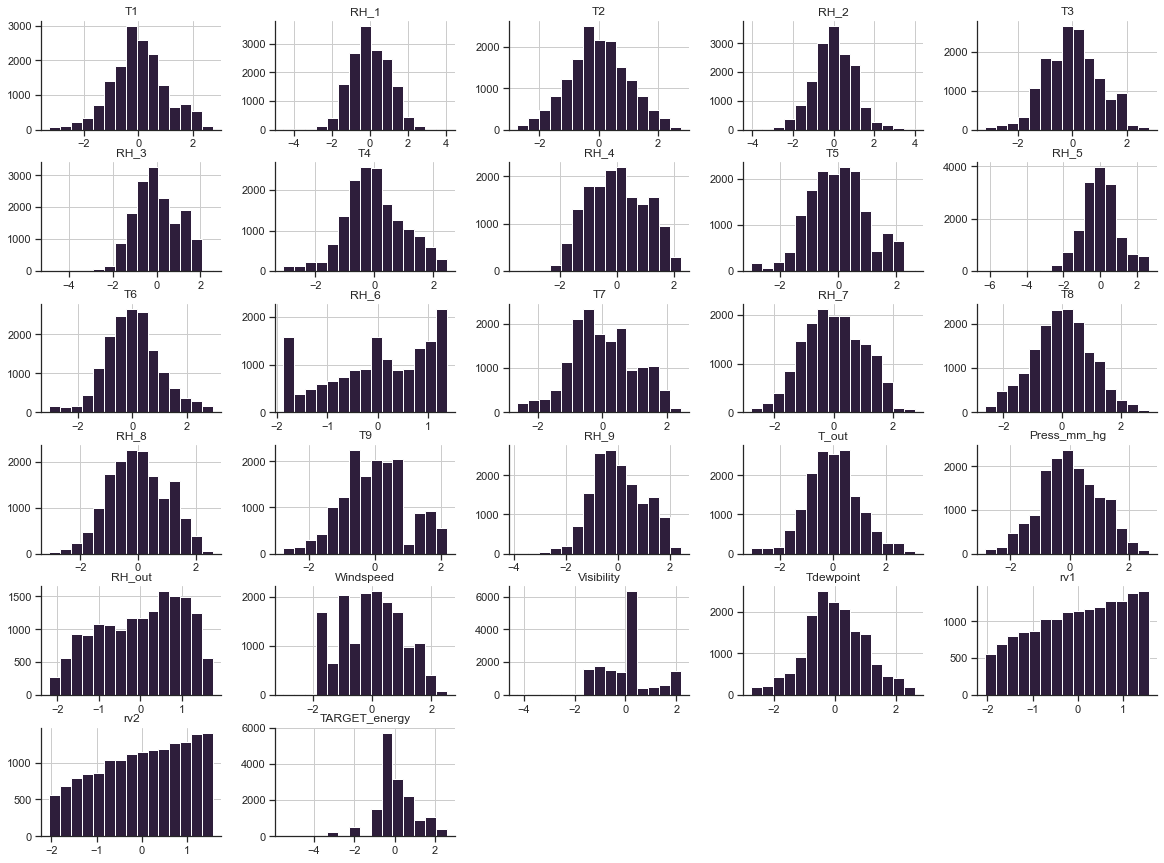

In [14]:
pt = PowerTransformer()
ss = StandardScaler()
qt = QuantileTransformer()
mms = MinMaxScaler()

col_names = eda.columns
pd.DataFrame(pt.fit_transform(eda.drop(columns='date')), columns=col_names[1:]).hist(bins=15, figsize=(20,15))

plt.show()

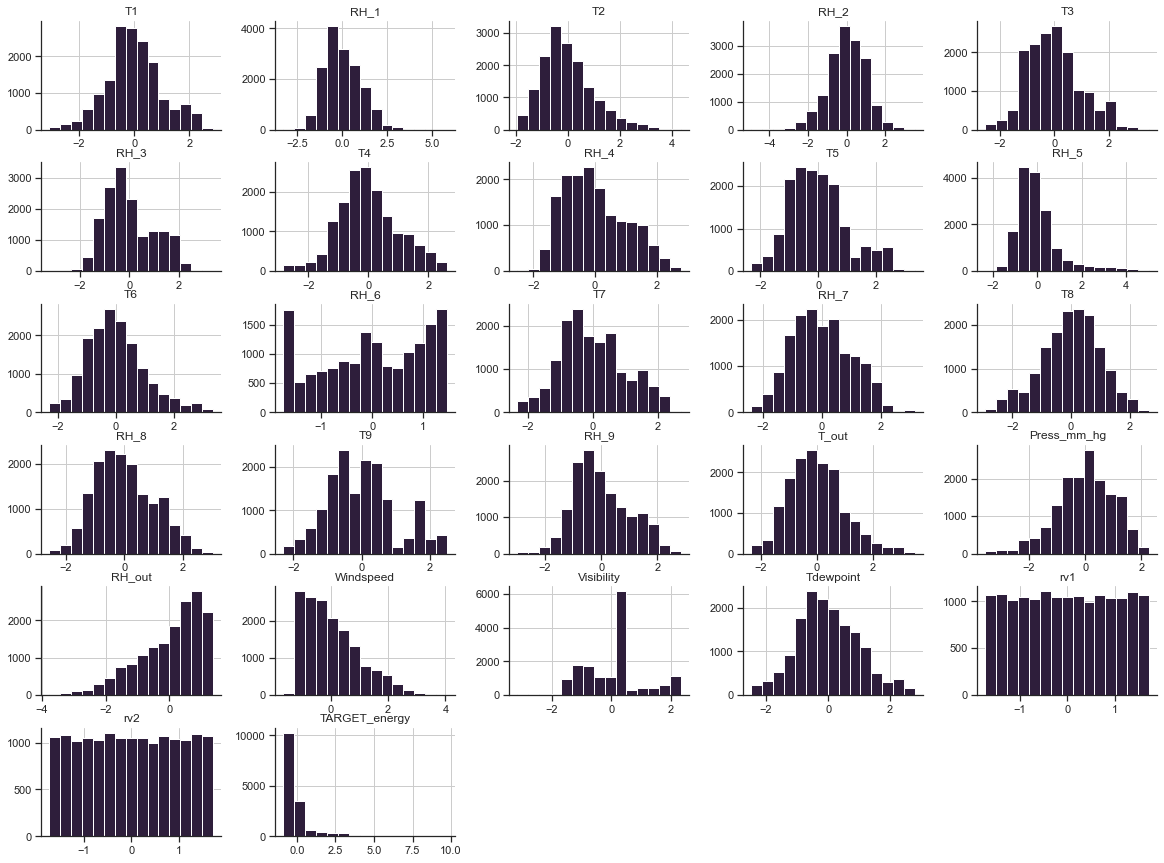

In [15]:
pd.DataFrame(ss.fit_transform(eda.drop(columns='date')), columns=col_names[1:]).hist(bins=15, figsize=(20,15))
plt.show()

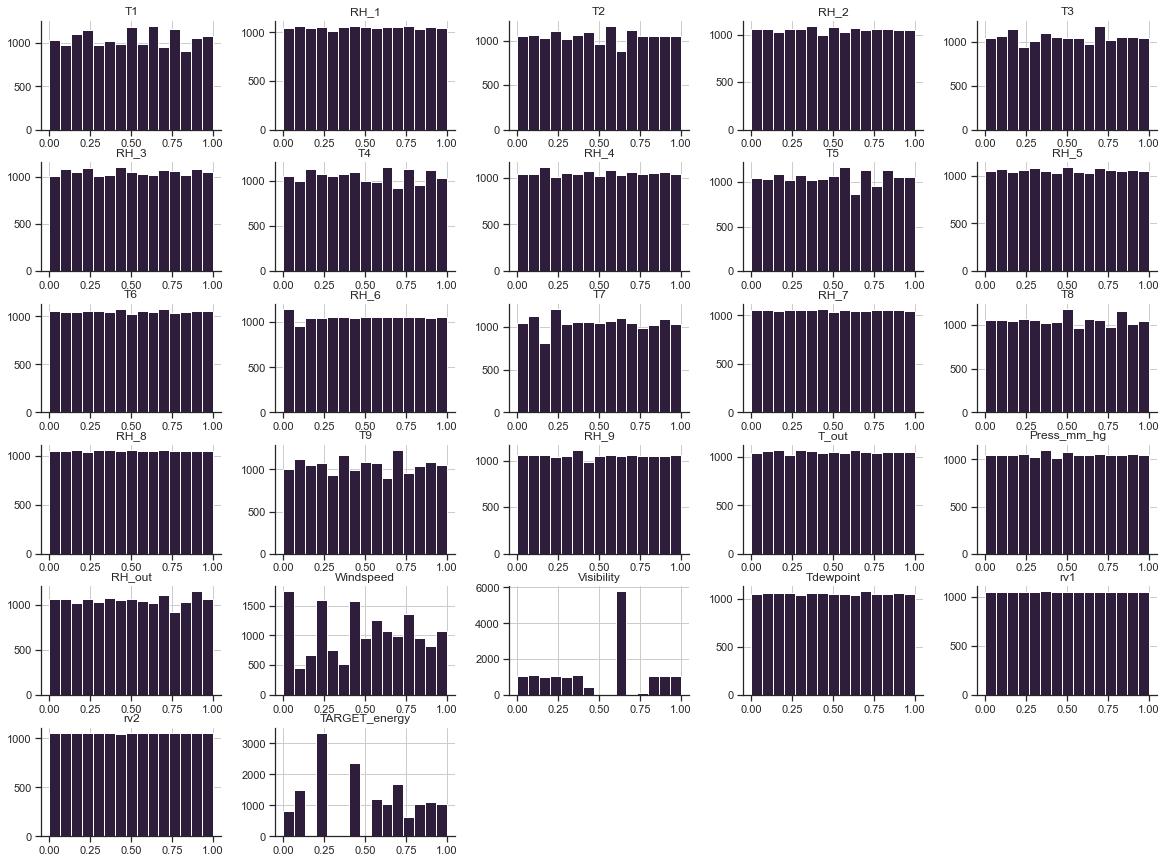

In [16]:
pd.DataFrame(qt.fit_transform(eda.drop(columns='date')), columns=col_names[1:]).hist(bins=15, figsize=(20,15))
plt.show()

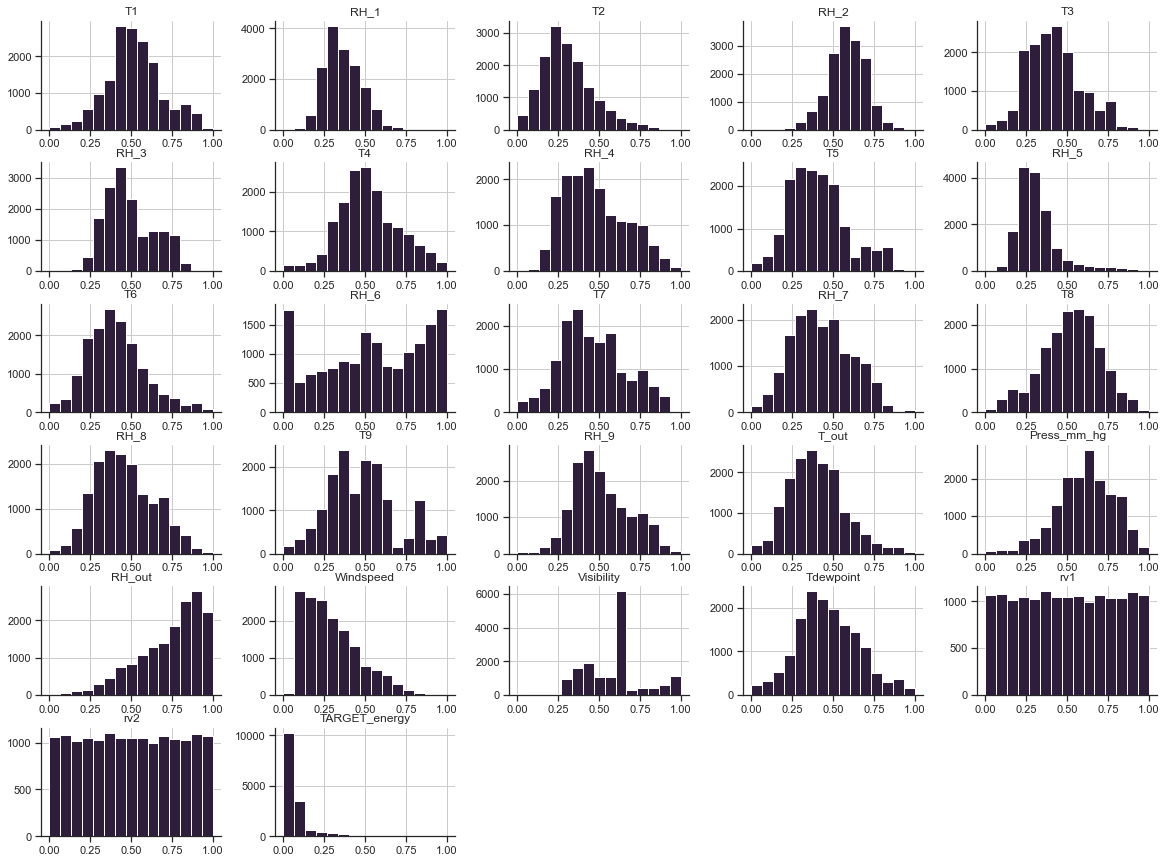

In [17]:
pd.DataFrame(mms.fit_transform(eda.drop(columns='date')), columns=col_names[1:]).hist(bins=15, figsize=(20,15))
plt.show()

#### Power Transformer
This seems to be the best type of transformation all round, providing almost all variables including the target variable with a normal distribution as desired in most machine learning models. RH_6 (outside humidity, north of building) seems to have trouble conforming to a normal distribution as it seems bi-modal and this transformation does the best.

#### Standard Scaler
This transforms most of the features well, however, doesn't deal with the atypical distribution of the target feature, RH_out (outside humidity), windspeed and to some extent visibility. 

#### Quantile Transformer
This transformation transforms most of the normally distributed data to a uniform distribution which is not desired, however, visibility which is grouped around the median is spread in a better way than other distributions so an ensemble method could be attempted here.

#### MinMax Scaler
This transform scales values between 0 and 1, for the purpose of some models such as ANNs. As most of the data is distributed normally, and there are no signficant outliers, this method works well. Additionally, many of the metrics are already in percentages, maintaing consistency between these features.

## Feature Engineering
#### Feature: Date
Additional features will be required to explain month, seasonality, weekend, hour and peak. We have defined peak as any time between 7am and 10pm. Season is ordinal, so we can one hot encode for a suitable result. However, the graph below indicates that we are in the northern hemisphere, which should be noted. There are no patterns that can be observed over time and energy use, outside of more energy used during peak periods. Temperature falls during the evening hours and rises during daylight hours as expected.

In [18]:
sdt = SimpleDateTransformer(['date'])
eda = pd.merge(eda, sdt.fit_transform(eda), left_index=True, right_index=True)
eda['date'] = pd.to_datetime(eda['date'])
eda.head()

,date,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,TARGET_energy,hour,month,weekend,season,peak
0,2016-02-20 13:20:00,21.530000,45.096667,20.600000,40.500000,21.474,42.40,18.323333,46.10,17.600000,54.264286,9.963333,92.656667,17.70,39.663333,20.650000,47.895000,17.70,44.200000,9.500000,755.000000,92.000000,5.333333,32.666667,8.200000,48.717990,48.717990,310,13,2,1,1,1
1,2016-01-23 06:20:00,17.290000,43.200000,16.356667,43.290000,17.700,41.20,15.300000,42.53,15.533333,48.961111,6.466667,99.900000,15.69,38.090000,16.655556,45.971667,15.19,42.433333,5.900000,766.866667,99.666667,4.000000,19.000000,5.833333,42.204855,42.204855,20,6,1,1,1,0
2,2016-04-02 09:50:00,20.890000,39.400000,18.790000,42.700000,21.790,37.40,19.790000,38.40,19.290000,45.090000,10.566667,37.993333,19.89,33.900000,21.200000,39.590000,19.60,37.730000,7.600000,757.983333,82.500000,1.833333,64.000000,4.716667,40.133645,40.133645,50,9,4,1,2,1
3,2016-02-07 12:40:00,21.133333,44.500000,20.500000,42.156667,21.500,43.59,18.790000,43.20,19.055556,59.102222,8.926667,64.193333,18.79,37.637778,20.890000,46.850556,19.10,44.933333,8.133333,745.966667,73.333333,8.333333,40.000000,3.533333,24.570344,24.570344,50,12,2,1,1,1
4,2016-04-21 19:50:00,23.000000,37.163333,22.500000,35.363333,23.200,36.40,22.890000,34.29,20.790000,41.290000,16.430000,1.000000,22.20,32.441429,23.000000,38.463333,20.20,35.730000,15.783333,759.516667,54.666667,4.000000,40.000000,6.566667,18.195913,18.195913,100,19,4,0,2,1


#### Cyclical Time Transformation
Hour, season, day_of_week, month are all cyclical datapoints that aren't represented in the current data. For example, 0 and 23 should be the same distance as 1 and 2 when measuring hours. Instead of encoding these categorically, we can apply a sine/ cosine transformation to each of the features to keep the cyclical nature of this data 

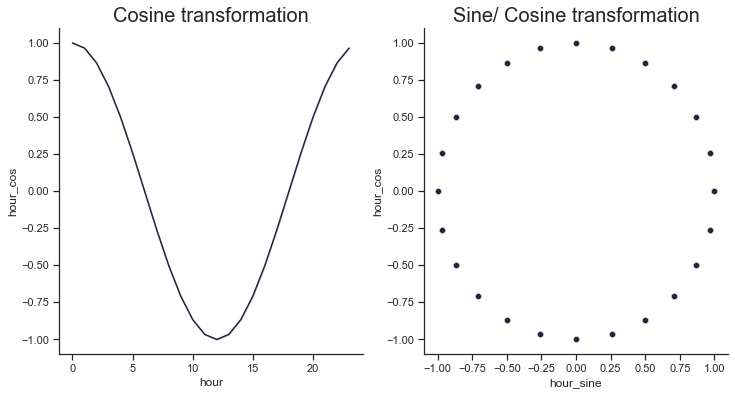

In [19]:
eda['hour_sine'] = np.sin(2*np.pi*eda['hour']/24)
eda['hour_cos'] = np.cos(2*np.pi*eda['hour']/24)

fig, ax = plt.subplots(1, 2, figsize=(12,6))

sns.lineplot(data=eda, x='hour', y='hour_cos', ax=ax[0])
sns.scatterplot(data=eda, x='hour_sine', y='hour_cos', ax=ax[1])

ax[0].set_title('Cosine transformation', fontsize=20)
ax[1].set_title('Sine/ Cosine transformation', fontsize=20)

plt.show()

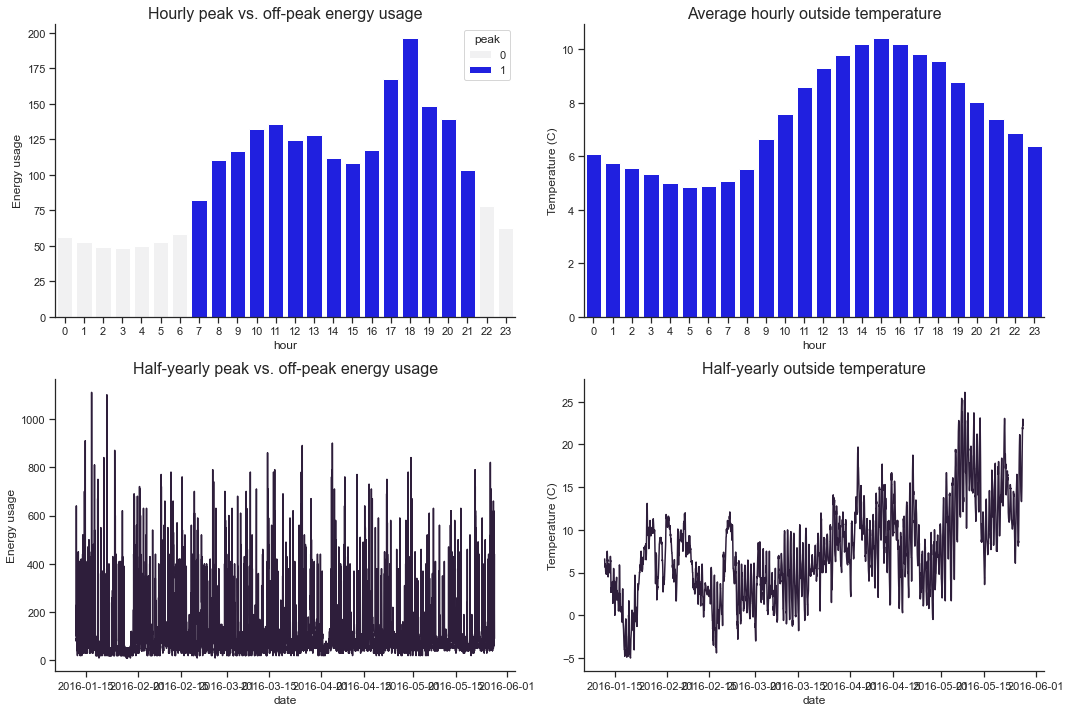

In [20]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

sns.barplot(data=eda, x='hour', y='TARGET_energy', hue='peak', color='b', dodge=False, ci=None, ax=ax[0,0])
sns.barplot(data=eda, x='hour', y='T_out', color='b', dodge=False, ci=None, ax=ax[0,1])
sns.lineplot(data=eda, x='date', y='TARGET_energy', ax=ax[1,0])
sns.lineplot(data=eda, x='date', y='T_out', ax=ax[1,1])

ax[0,0].set_title('Hourly peak vs. off-peak energy usage', fontsize=16)
ax[0,0].set_ylabel('Energy usage')
ax[0,1].set_title('Average hourly outside temperature', fontsize=16)
ax[0,1].set_ylabel('Temperature (C)')
ax[1,0].set_title('Half-yearly peak vs. off-peak energy usage', fontsize=16)
ax[1,0].set_ylabel('Energy usage')
ax[1,1].set_title('Half-yearly outside temperature', fontsize=16)
ax[1,1].set_ylabel('Temperature (C)')

plt.tight_layout()
plt.show()

#### Feature: Season
Similar logic to the cycles of time can be applied to seasons, however, it is better to just use a cos transformation, whereby, 0 and 2 are furthest apart (Summer and Winter) and 1 and 3 are closest (Spring and Autumn).

In [21]:
ct = CyclicalTransformer(['date'])
ct.fit_transform(eda)[['peak', 'weekend']]

,peak,weekend
0,1,1
1,0,1
2,1,1
3,1,1
4,1,0
...,...,...
15783,0,0
15784,0,1
15785,0,0
15786,1,0


#### Feature: RH_6 (Outside Humidity)
There are a significant number of observations when humidity was at 1%. The distributions seem normal, albeit there seems to be high multicollinearity between other variables, but there is nothing further interesting of note. 

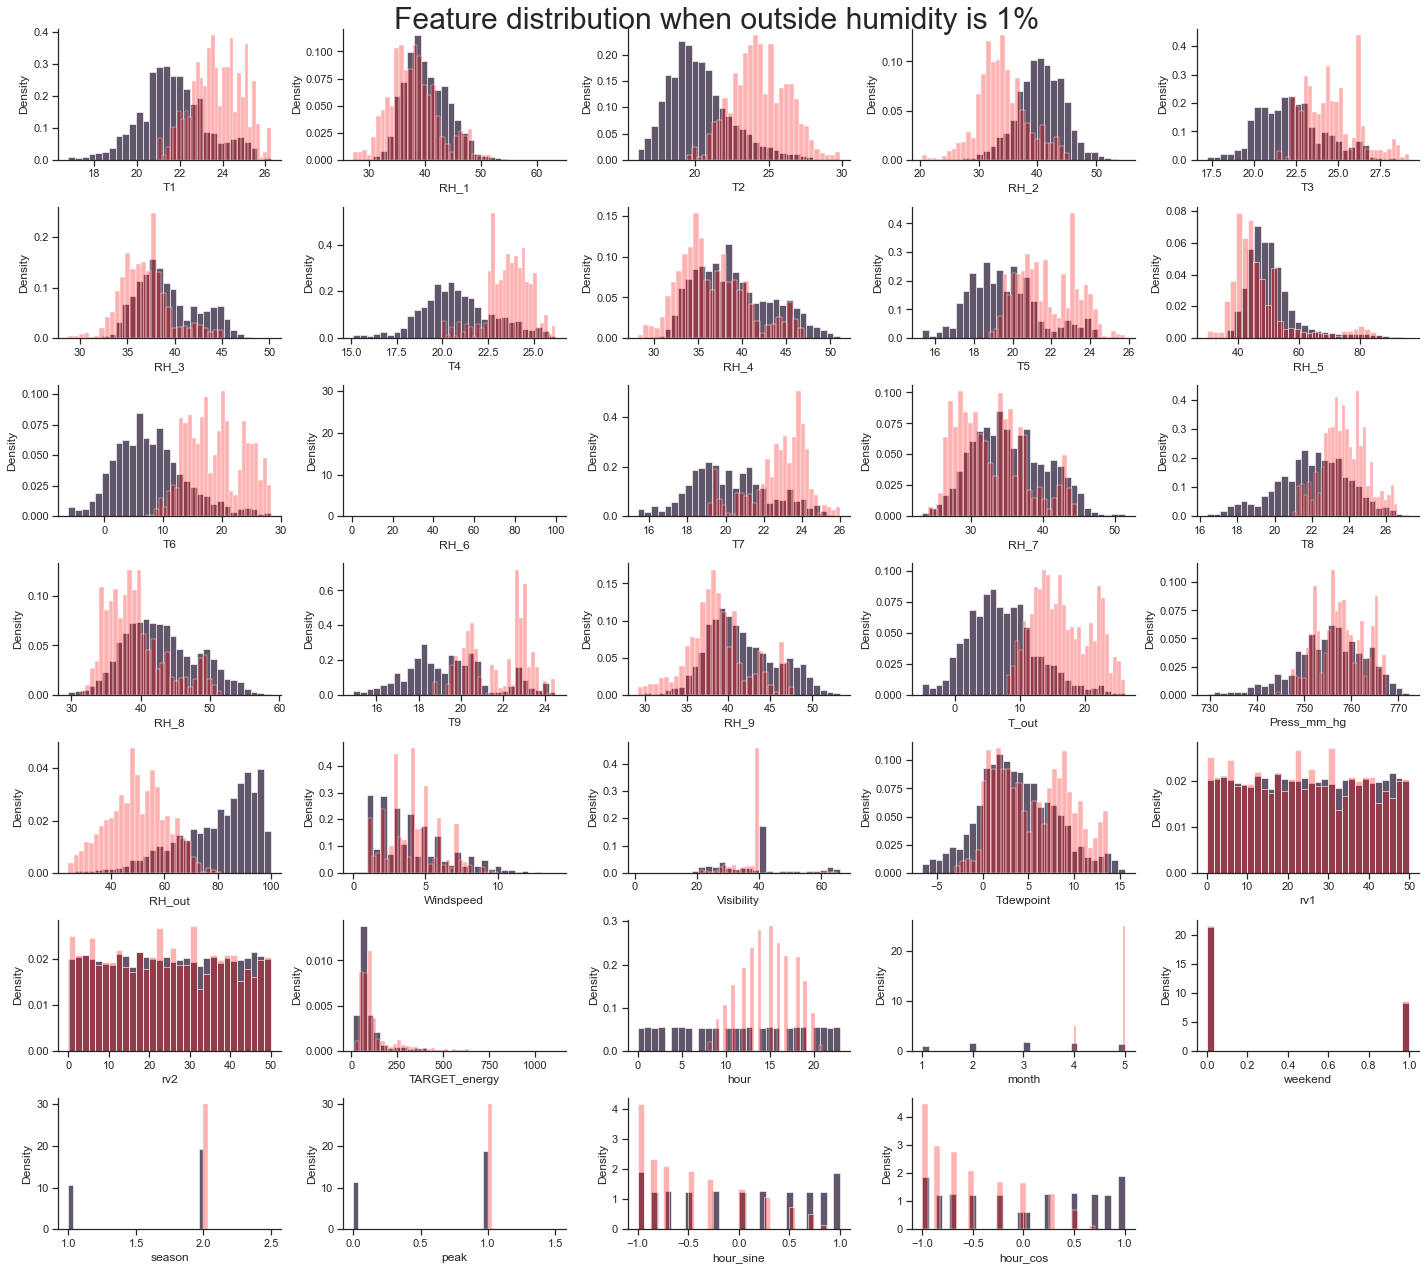

In [22]:
fig = plt.figure(figsize=(20,20))
fig.suptitle('Feature distribution when outside humidity is 1%', fontsize=30)

for i, col in enumerate(eda.select_dtypes(include='number').columns):
    fig.add_subplot(8,5,i+1)
    sns.histplot(eda[col], bins=30, stat='density')
    sns.histplot(eda[eda['RH_6']==1][col], bins=30, color='r', alpha=0.3, stat='density')

fig.tight_layout()
plt.show()


#### Feature: Random Variable 1, Random Variable 2
Random variables 1 and 2 can be dropped. These are redundant features.

In [23]:
eda = eda.drop(columns=['rv1', 'rv2'])

#### Feature: Visibility
A visibility of 40km is in fact the median of the data set, indicating that these may have been missing values during data collection. Interestingly, visibility at night-time is allegedly 1/3 of visibility during the peak of the day which seems strange. In general, visibility seems to indicate higher temperatures which is what we would expect. Otherwise, the filtered data seems to compare nicely to the rest of the dataset and follow the distributions close enough.

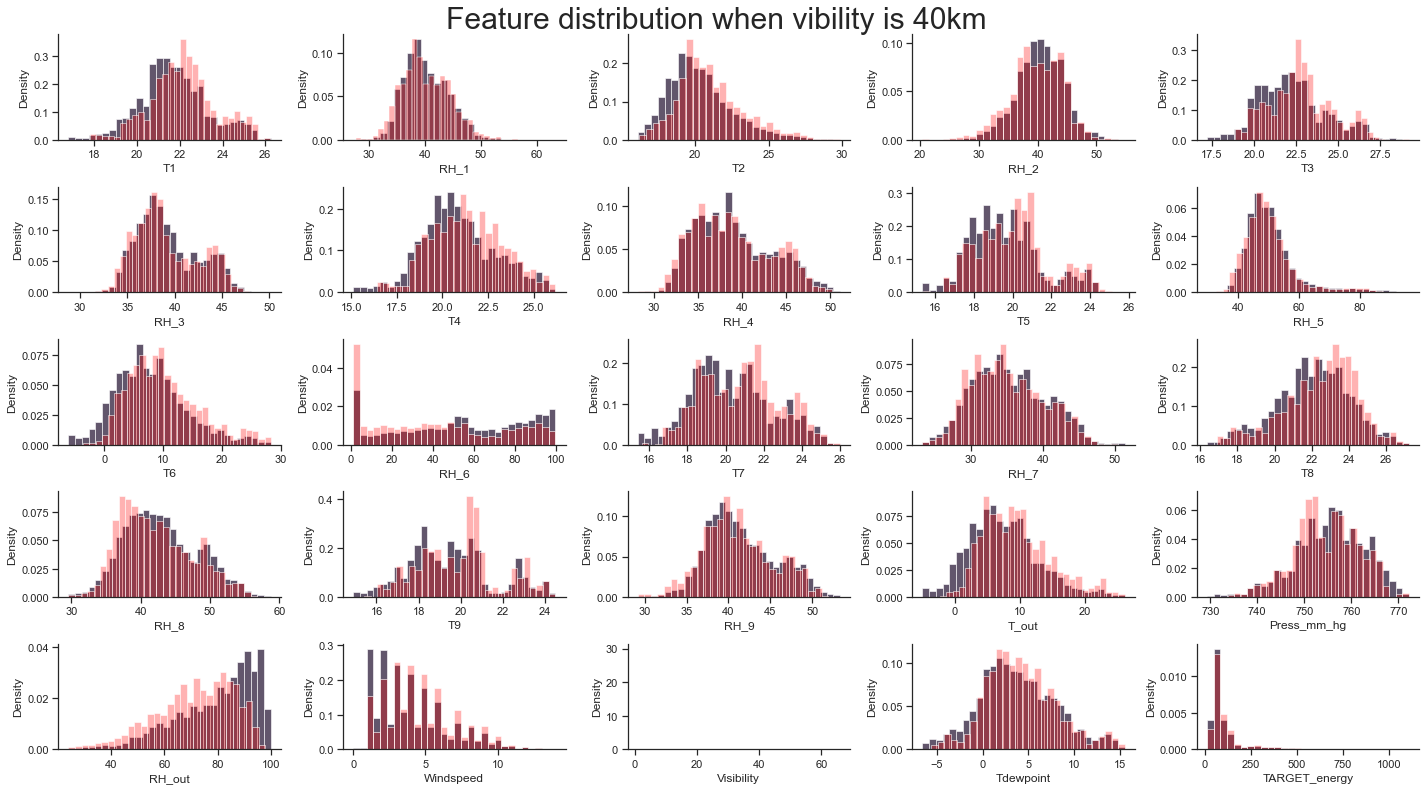

In [32]:
fig = plt.figure(figsize=(20,15))
fig.suptitle('Feature distribution when vibility is 40km', fontsize=30)

for i, col in enumerate(eda.select_dtypes(include='number').columns):
    fig.add_subplot(7,5,i+1)
    sns.histplot(eda[col], bins=30, stat='density')
    sns.histplot(eda[eda['Visibility']==40][col], bins=30, color='r', alpha=0.3, stat='density')

fig.tight_layout()
plt.show()

## Feature Importance
#### Correlation
**TARGET_energy** seems to be mostly correlated with **peak/ off-peak** time periods. There is high multicollinearity between most of the **humidity** features, and between most of the **temperature** features that will cause problems in training a regression model. Interestingly, **RH_6**, which we investigated earlier seems to be inversely correlated with most features. This could be explained due to it being a measurement of outside the home, where the desired climate would generally be the opposite. This is supported by the other inversely related features being measurements from the outside station. 

Another humidity value that is abnormal when compared to the other variables is **RH_5**, the measurement of humidity in the bathroom. Although it is not collinear with the target feature, it is interesting to note that it does not follow the trend of other humidity measurements. There also seem to be two distinct clusters in the features lower and upper bounds when comparing it to the target feature.

**Temperature** features also seem to be relatively good at predicting the target variable with a slight positive correlation.

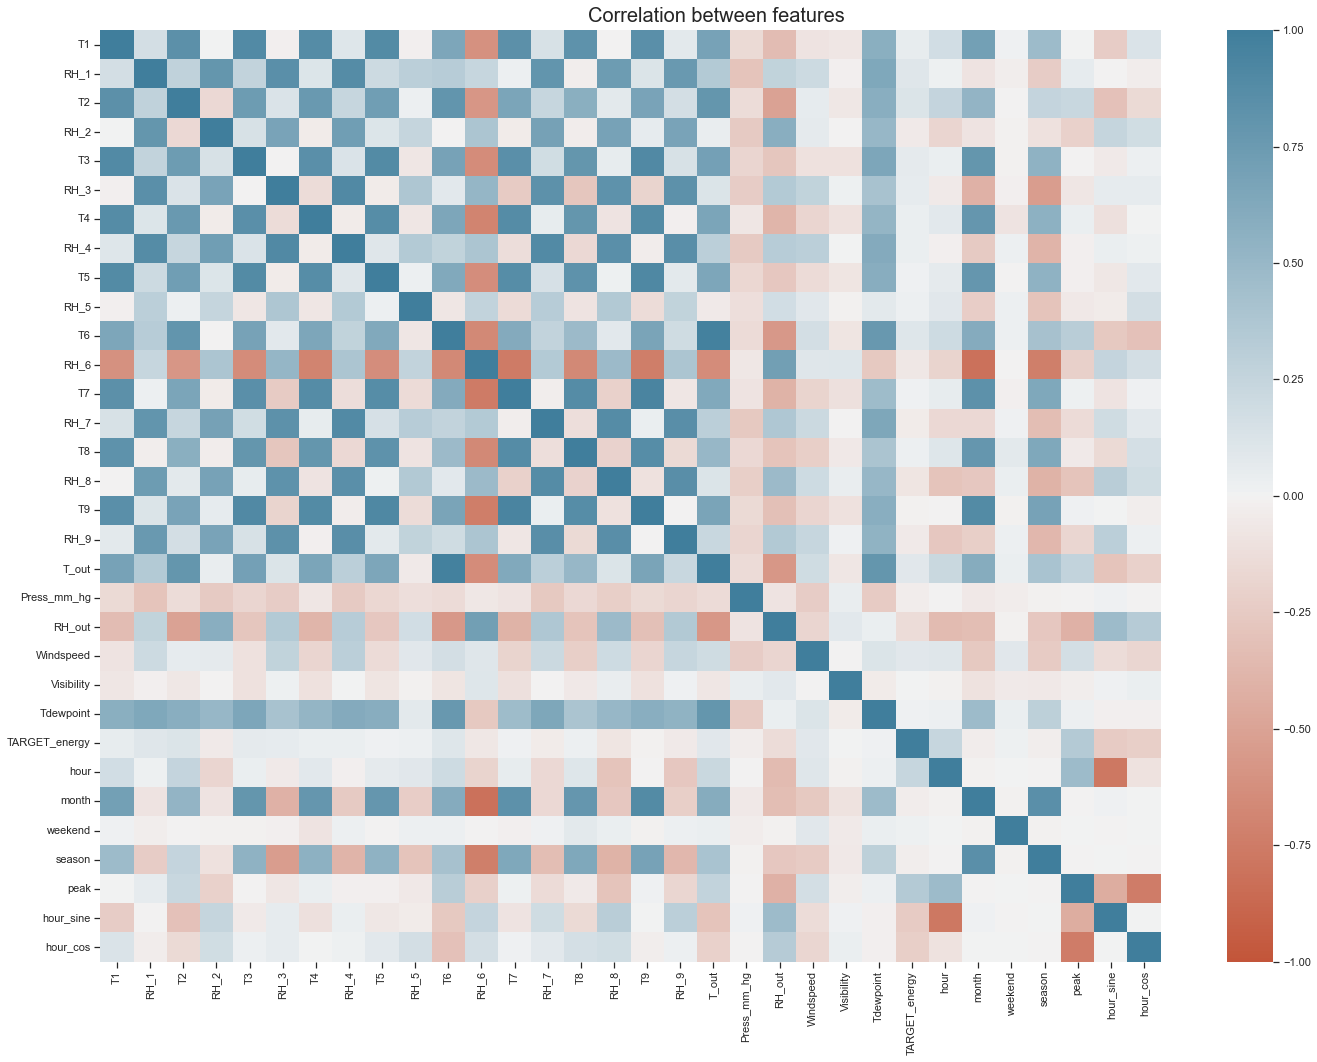

In [25]:
fig = plt.figure(figsize=(20,15))
cmap = sns.diverging_palette(20, 230, as_cmap=True)

corr = eda.corr()
sns.heatmap(corr, annot=False, cmap=cmap, vmin=-1, vmax=1)
fig.suptitle('Correlation between features', fontsize=20)

fig.tight_layout()
plt.show()

### Multicollinearity
The data is clearly very multicollinear between some of the independent features, for example, between temperate metrics and between humidity metrics. Although these won't affect the overall outcome of the predictive model, the multicollinear features will be overcompensated in the model and reduce the interpretability. It will be difficult to understand which features are causing change in the dependent feature.

In [26]:
eda = pd.read_csv('data/train.csv').drop(columns=['rv1', 'rv2'])
T_cols = [col for col in eda.columns if re.search('T\d', col)]
RH_cols = [col for col in eda.columns if re.search('RH_[1-4,7-9]', col)]

t_at = AverageTransformer(T_cols, ['T_avg'])
rh_at = AverageTransformer(RH_cols, ['RH_avg'])

preprocess = make_column_transformer((t_at, T_cols), (rh_at, RH_cols), (DateTransformer(['date']), ['date']), remainder='passthrough')

multicol = pd.DataFrame(preprocess.fit_transform(eda), columns=preprocess.get_feature_names_out())

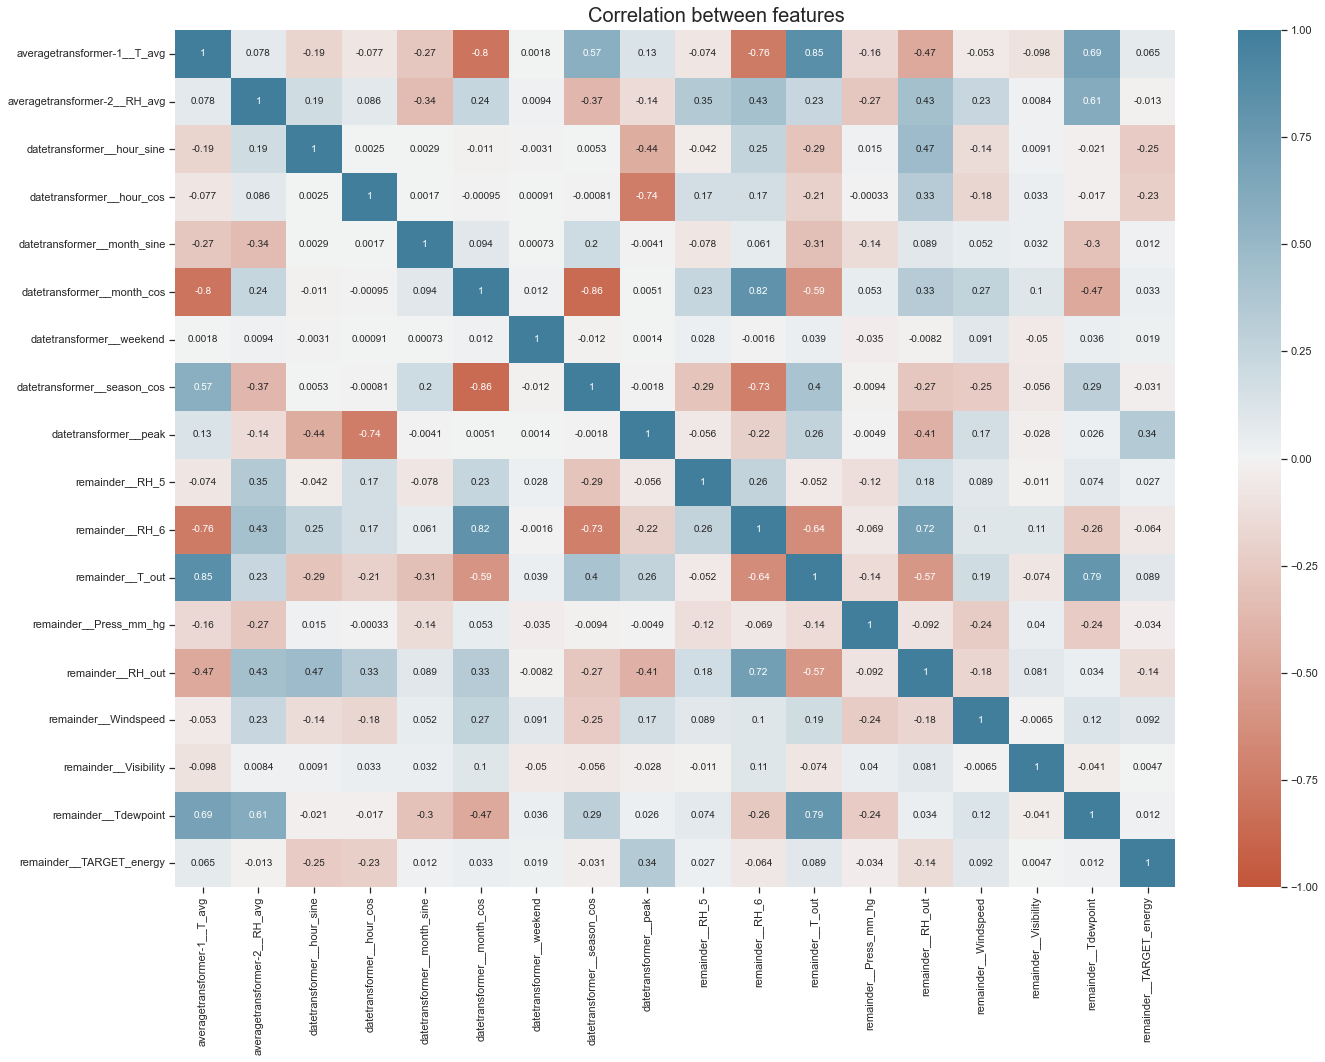

In [27]:
fig = plt.figure(figsize=(20,15))
cmap = sns.diverging_palette(20, 230, as_cmap=True)

corr = multicol.corr()
sns.heatmap(corr, annot=True, cmap=cmap, vmin=-1, vmax=1)
fig.suptitle('Correlation between features', fontsize=20)

fig.tight_layout()
plt.show()

#### Variance Inflation Factor
We can see that including all the variables result in many collinearities, where a VIF of more than 5 is too high and the independent features are no longer independent. In terms of the features that are collinear, it makes sense as they pertain to climate and temperature. If it is a cold day, you expect the outside temperature and humidity to be lower than a warmer day. This is also true for internal temperature, where residents will want to warm their house when it is cooler outside. What this indicates, is that some feature selection may be useful in generating a more performance and explainable linear regression model. At this stage, most variables are above a VIF of 5, indicating that feature selection may be useful.

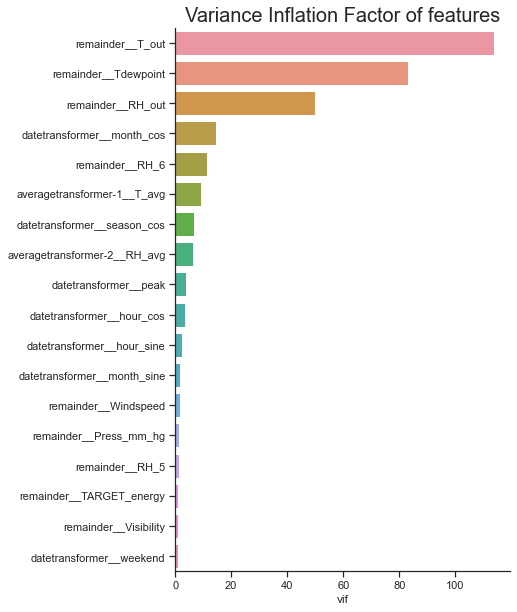

In [28]:
vif = calculate_vif(df=multicol, features=multicol.columns).sort_values(by='vif', ascending=False)

fig = plt.figure(figsize=(6,10)) 

sns.barplot( x=vif['vif'], y=vif.index, orient='h')

plt.title('Variance Inflation Factor of features', fontsize=20)
plt.show()

In [29]:
X = multicol.iloc[:,:-1]
y = multicol.iloc[:,-1]

l1 = Lasso()
l1.fit(X,y)
l1_feature_importance = pd.DataFrame(zip(X.columns.to_list(), l1.coef_), columns=['feature', 'value']).sort_values(by='value', key=abs, ascending=False)


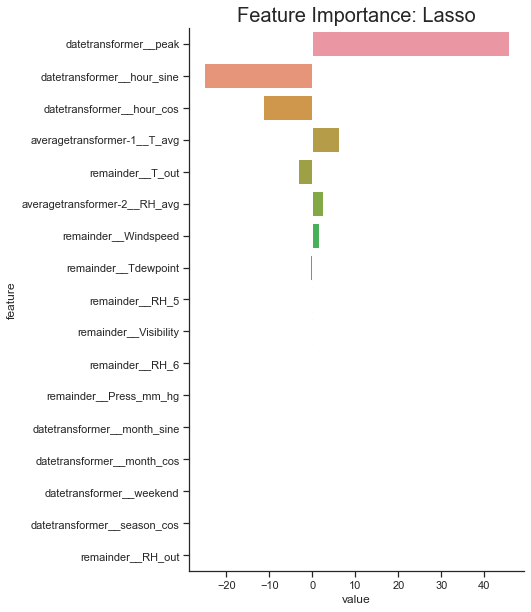

In [30]:
fig = plt.figure(figsize=(6,10)) 

sns.barplot(data=l1_feature_importance, x='value', y='feature', orient='h')

plt.title('Feature Importance: Lasso', fontsize=20)
plt.show()

In [31]:
l1_feature_importance[:12].index.to_list()

[8, 2, 3, 0, 11, 1, 14, 16, 9, 15, 10, 12]